In [10]:
import numpy as np
import pandas as pd
import xarray as xr
import brom_functions as bf
import plot_functions as pf
import lmfit as lf
import non_linear_fit_functions as lff

#### Open an initial dataset (observed values)

In [11]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()

In [12]:
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)
levelface.describe()

,par,hice,snowthick,icesurft,temperature,salinity,sigma,turbulence,ammonium,nitrate,silicate,phosphate,oxygen,om_flux,chl_a
count,1095.000000,1095.0,1095.0,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1.095000e+03,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,56.332397,0.0,0.0,0.0,10.700646,30.484438,25.608339,0.000036,1.000000e-01,16.124231,10.462073,0.616338,332.543217,0.001395,18.844109
std,23.048964,0.0,0.0,0.0,5.691322,0.708197,1.594859,0.000031,1.791053e-15,13.724963,8.133727,0.406156,47.042972,0.000877,9.769495
min,21.644333,0.0,0.0,0.0,2.145531,29.219625,22.645143,0.000009,1.000000e-01,0.198307,0.754375,0.094500,255.017806,0.000155,0.000000
25%,33.247036,0.0,0.0,0.0,5.767865,29.952813,24.353865,0.000019,1.000000e-01,0.907292,3.564215,0.241964,294.762602,0.000520,12.971875
50%,58.778526,0.0,0.0,0.0,10.443795,30.572593,25.663931,0.000025,1.000000e-01,16.035938,5.939955,0.563480,324.720360,0.001395,19.532812
75%,79.421547,0.0,0.0,0.0,16.023899,30.967065,26.740268,0.000041,1.000000e-01,28.764583,19.211458,0.918029,362.263498,0.002270,24.846443
max,86.162720,0.0,0.0,0.0,19.109524,32.490208,29.768699,0.000312,1.000000e-01,40.072916,26.070694,1.504752,427.340630,0.002635,40.787321


In [13]:
par = levelface['par'].values[0:365].astype(np.float64)
temperature = levelface['temperature'].values[0:365].astype(np.float64)
nh4_data = levelface['ammonium'].values[0:365].astype(np.float64)
no3_data = levelface['nitrate'].values[0:365].astype(np.float64)
po4_data = levelface['phosphate'].values[0:365].astype(np.float64)
si_data = levelface['silicate'].values[0:365].astype(np.float64)
o2_data = levelface['oxygen'].values[0:365].astype(np.float64)
chl_a_data = levelface['chl_a'].values[0:365].astype(np.float64)
# daily irradiance
irradiance = par*86400/1000000 # convertion microM per second to M per day

#### There are some initial data

In [15]:
#some common variables
depth = 0.625; k=0; latitude=54.88; days = np.arange(0,364,1)
#nutrients
nh4 = np.zeros(365); nh4[0] = 2 
no2 = np.zeros(365); no2[0] = 1.5
no3 = np.zeros(365); no3[0] = no3_data[0] 
si = np.zeros(365); si[0] = si_data[0] 
po4 = np.zeros(365); po4[0] = po4_data[0] 
o2 = np.zeros(365); o2[0] = o2_data[0] 
#phy
phy = np.zeros(365); phy[0] = 90
# daily irradiance, convertion microM per second to M per day
irradiance = par*86400/1000000
#het
het = np.zeros(365); het[0] = 90
#om
poml = np.zeros(365); poml[0] = 100; pomr = np.zeros(365); pomr[0] = 100
doml = np.zeros(365); doml[0] = 50; domr = np.zeros(365); domr[0] = 50

#### There are some initial parameters

In [16]:
#horizontal advection
k_mix=0.1
#phy
knh4_lim=0.2; knox_lim=0.2; ksi_lim=0.2; kpo4_lim=0.2; pbm=8; alpha=0.04; kexc=0.015; kmortality=0.0001
#het
k_het_phy_gro=0.2; k_het_phy_lim=0.4; k_het_pom_gro=k_het_phy_gro; k_het_pom_lim=k_het_phy_lim
k_het_res=0.015; k_het_mort=0.1; uz=0.5; hz=0.5
#nitrification
k_nfix = 0.4; k_nitrif1=0.1; k_nitrif2=0.1; o2s_nf=5; k_anammox=0.8; o2s_dn=10
#om respiration
k_poml_doml=0.15; k_pomr_domr=0.00001; k_omox_o2=1; tref=0
k_doml_ox=0.1; k_poml_ox=0.02; k_domr_ox=0.1; k_pomr_ox=0.002

#### Run simulation

In [17]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, k_mix, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    nh4_data, no3_data, si_data, po4_data,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox)

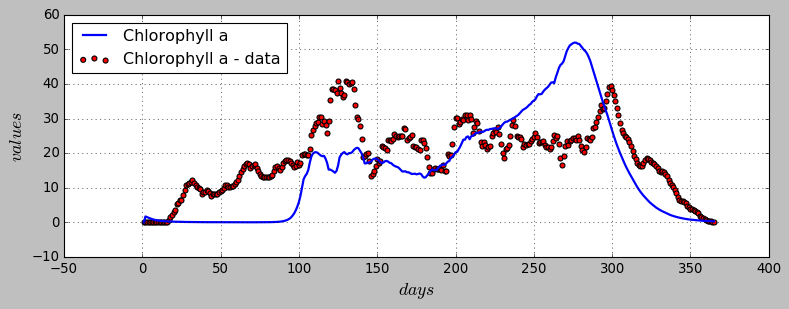

In [18]:
pf.plot_double(chl_a,'Chlorophyll a',chl_a_data,'Chlorophyll a - data')

#### Run least squares for phytoplankton - resudial function is constructed according to chl_a_data

In [19]:
params = lf.Parameters()
#horizontal advection
params.add('k_mix', value=k_mix)
#phy
params.add('knh4_lim', value=knh4_lim)
params.add('knox_lim', value=knox_lim)
params.add('ksi_lim', value=ksi_lim)
params.add('kpo4_lim', value=kpo4_lim)
params.add('pbm', value=pbm, vary=False)
params.add('alpha', value=alpha, vary=False)
params.add('kexc', value=kexc, vary=False)
params.add('kmort', value=kmortality, vary=False)
#het
params.add('k_het_phy_gro', value=k_het_phy_gro, vary=False)
params.add('k_het_phy_lim', value=k_het_phy_lim, vary=False)
params.add('k_het_pom_gro', value=k_het_pom_gro, vary=False)
params.add('k_het_pom_lim', value=k_het_pom_lim, vary=False)
params.add('k_het_res', value=k_het_res, vary=False)
params.add('k_het_mort', value=k_het_mort, vary=False)
params.add('uz', value=uz, vary=False)
params.add('hz', value=hz, vary=False)
#nitrification
params.add('k_nfix', value=k_nfix, vary=False)
params.add('k_nitrif1', value=k_nitrif1, vary=False)
params.add('k_nitrif2', value=k_nitrif2, vary=False)
params.add('o2s_nf', value=o2s_nf, vary=False)
params.add('k_anammox', value=k_anammox, vary=False)
params.add('o2s_dn', value=o2s_dn,vary=False)
#OM
params.add('k_poml_doml', value=k_poml_doml, vary=False)
params.add('k_pomr_domr', value=k_pomr_domr, vary=False)
params.add('k_omox_o2', value=k_omox_o2, vary=False)
params.add('tref', value=tref, vary=False)
params.add('k_doml_ox', value=k_doml_ox, vary=False)
params.add('k_poml_ox', value=k_poml_ox, vary=False)
params.add('k_domr_ox', value=k_domr_ox, vary=False)
params.add('k_pomr_ox', value=k_pomr_ox, vary=False)

In [20]:
mini = lf.Minimizer(lff.residual_phy, params,
                    fcn_args=(depth, k, latitude, days, temperature,
                              nh4, no2, no3, si, po4, o2,
                              nh4_data, no3_data, si_data, po4_data,
                              phy, par, irradiance,
                              het,
                              poml, doml, pomr, domr,
                              chl_a_data))

In [21]:
foo = lff.run_least_squares(mini)

In [22]:
kmix     = lff.return_par_values(foo, 'k_mix')
knh4_lim = lff.return_par_values(foo, 'knh4_lim')
knox_lim = lff.return_par_values(foo, 'knox_lim')
ksi_lim  = lff.return_par_values(foo, 'ksi_lim')
kpo4_lim = lff.return_par_values(foo, 'kpo4_lim')
pbm      = lff.return_par_values(foo, 'pbm')
alpha    = lff.return_par_values(foo, 'alpha')
kexc     = lff.return_par_values(foo, 'kexc')
kmort    = lff.return_par_values(foo, 'kmort')
k_het_phy_gro = lff.return_par_values(foo, 'k_het_phy_gro')
k_het_phy_lim = lff.return_par_values(foo, 'k_het_phy_lim')
k_het_pom_gro = lff.return_par_values(foo, 'k_het_pom_gro')
k_het_pom_lim = lff.return_par_values(foo, 'k_het_pom_lim')
k_het_res     = lff.return_par_values(foo, 'k_het_res')
k_het_mort    = lff.return_par_values(foo, 'k_het_mort')

In [23]:
print(kmix);

0.15487236655839307


In [24]:
print(knh4_lim, knox_lim, ksi_lim, kpo4_lim);

0.15937171468766292 5.216381702610378 0.5849853346317835 0.15472480006427286


In [25]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, k_mix, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    nh4_data, no3_data, si_data, po4_data,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox)

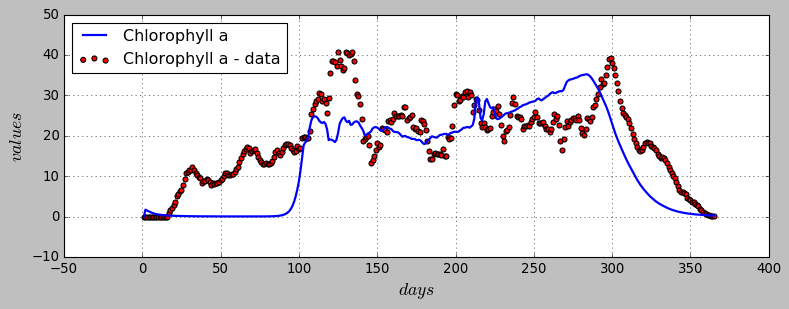

In [26]:
pf.plot_double(chl_a,'Chlorophyll a',chl_a_data,'Chlorophyll a - data')